In [6]:
#-*-coding:utf-8-*-
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import tensorflow as tf
from datetime import timedelta
import autokeras as ak
from kerastuner import HyperModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
# from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

#만든 모듈을 불러옴
import sys
from importlib import reload
sys.path.append('Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/') 
print(sys.path)
import Timeseries_module_ykkim as tsm

['C:\\Users\\KIMYEONKYOUNG\\Desktop\\2021 AI 빅데이터팀\\메탈 수요예측\\code', 'C:\\ProgramData\\Anaconda3\\python38.zip', 'C:\\ProgramData\\Anaconda3\\DLLs', 'C:\\ProgramData\\Anaconda3\\lib', 'C:\\ProgramData\\Anaconda3', '', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\KIMYEONKYOUNG\\.ipython', 'Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/', 'Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/']


<ipython-input-6-e18b3650c641>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
data=pd.read_excel('C:/Users/KIMYEONKYOUNG/Desktop/2021 AI 빅데이터팀/메탈 수요예측/data/pre_v0.1_합계제거.xlsx')

In [15]:
data.columns

Index(['YEAR', 'MONTH', '삼성전자_이동', '무한_이동', '삼성스텐레이져_이동', 'SHC_이동', '성진이앤씨_이동',
       '티이씨앤코_이동', '상생솔루션_이동', '에어텍_이동',
       ...
       'AMAPAI(인도)_실적', 'DIA(인도)_실적', 'Hitachi금속_실적', 'PHILCO_실적',
       'Videocon_실적', 'Panasonic(인도)_실적', 'Ess Kay_실적', 'jmf_실적', '실적 합',
       'Time'],
      dtype='object', length=321)

In [39]:
column='삼성전자_실적'
dd = tsm.ts_data(data,column)

In [40]:
# standard scaler
# scal = StandardScaler()
scal =MinMaxScaler()
# scal = RobustScaler()
dd_t = scal.fit_transform(dd)
dd_t=pd.DataFrame(dd_t,index=dd.index)

In [121]:
#for graph
predict_month=1
n_steps = 5
train,test_nu=tsm.TS_holdout(dd,predict_month)
train_nu,test=tsm.TS_holdout(dd,predict_month*n_steps)

# train,test split

In [42]:
print(dd_t.index.min(), '~',dd_t.index.max() )

2017-01-01 00:00:00 ~ 2021-03-01 00:00:00


In [93]:
test_cutoff_date= dd_t.index.max() - timedelta(days=1*28) # test : 1개월
val_cutoff_date=dd_t.index.max() - timedelta(days=20*30) # validation : 10개월

In [97]:
df_test = dd_t[dd_t.index >=  '2020-11-01']
df_val = dd_t[(dd_t.index > val_cutoff_date) & (dd_t.index <= test_cutoff_date)]
df_train = dd_t[(dd_t.index <= test_cutoff_date )   ]#val_cutoff_date

# data preprocessing

In [182]:
# # standard scaler
# scal = StandardScaler()
# df_train_t = scal.fit_transform(df_train)
# scal.partial_fit(df_val)
# df_val_t=scal.transform(df_val)

In [81]:
# dateaframe to tensor
nd=np.asarray(df_train)
ndd=nd.reshape(len(df_train),)

nv=np.asarray(df_val)
nvv=nv.reshape(len(df_val),)

In [82]:
n_steps = 5
(train_x, train_y) = tsm.split_sequence(ndd, n_steps) 
print(train_x.shape) 
print(train_y.shape)
# from keras.preprocessing.sequence import TimeseriesGenerator
# generator = TimeseriesGenerator(train, targets=train, length=5, batch_size=1)
# generator
# train_x

(45, 5)
(45,)


In [83]:
(val_x, val_y) = tsm.split_sequence(nvv, n_steps) 
print(val_x.shape) 
print(val_y.shape)

(14, 5)
(14,)


In [84]:
n_features = 1 
train_x = train_x.reshape(train_x.shape[0], n_steps, n_features)
val_x = val_x.reshape(val_x.shape[0], n_steps, n_features)

print(train_x.shape)
print(val_x.shape) 

(45, 5, 1)
(14, 5, 1)


In [189]:
#########timesplit 

In [24]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv=TimeSeriesSplit(n_splits=5) #, test_size=1
# print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [79]:
# for train_index, test_index in tscv.split(x):
#         print("TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_test = x[train_index], x[test_index]
#         y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22 23 24 25 26 27 28 29 30]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30] TEST: [31 32 33 34 35 36 37 38 39]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39] TEST: [40 41 42 43 44 45 46 47 48]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48] TEST: [49 50 51 52 53 54 55 56 57]


In [77]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score = []
# for tr_index, val_index in tscv.split(X_train):
#     X_tr, X_val = X_train[tr_index], X_train[val_index]
#     y_tr, y_val = y_train[tr_index], y_train[val_index]
#     for mf in np.linspace(100, 150, 6):
#         for ne in np.linspace(50, 100, 6):
#             for md in np.linspace(20, 40, 5):
#                 for msl in np.linspace(30, 100, 8):
#                     rfr = RandomForestRegressor(
#                         max_features=int(mf),
#                         n_estimators=int(ne),
#                         max_depth=int(md),
#                         min_samples_leaf=int(msl))
#                     rfr.fit(X_tr, y_tr)
#                     score.append([i,
#                                   mf, 
#                                   ne,
#                                   md, 
#                                   msl, 
#                                   rfr.score(X_val, y_val)])
#     i += 1

NameError: name 'RandomForestRegressor' is not defined

In [85]:
# train(train,val)
# Hyperparameter Setting
BATCH_SIZE = 1
BUFFER_SIZE=100

# # Dataset -> Tensor
train_univariate = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# LSTM model(univariate, simple)_train

In [86]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model

In [87]:
path_checkpoint = "lstm_model_checkpoint_try4.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=100, mode='auto')# mode=auto loss면 최저값100번정도 반복되면 정지, acc면 최고값이 100번정도 반복되면 정지

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,)

In [88]:
# Build Simple LSTM Model
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),#
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(20, activation = 'relu', input_shape=(n_steps,1),return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(10, activation = 'relu', input_shape=(n_steps,1)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5),   
    tf.keras.layers.Dense(1)
])


simple_lstm_model.compile(optimizer='adam', loss='mse',metrics=['mse'])


In [89]:
# Train the Model(val)
EVALUATION_INTERVAL = 100
EPOCHS = 1000

history=simple_lstm_model.fit(train_univariate , epochs=EPOCHS,validation_data=val_univariate,steps_per_epoch=EVALUATION_INTERVAL,validation_steps=1,verbose=1,callbacks=[es_callback, modelckpt_callback])

Epoch 1/1000
100/100 [==============================] - 10s 22ms/step - loss: 0.1826 - mse: 0.1826 - val_loss: 0.0460 - val_mse: 0.0460

Epoch 00001: loss improved from inf to 0.11581, saving model to lstm_model_checkpoint_try4.h5
Epoch 2/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0823 - val_mse: 0.0823

Epoch 00002: loss improved from 0.11581 to 0.06791, saving model to lstm_model_checkpoint_try4.h5
Epoch 3/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0998 - val_mse: 0.0998

Epoch 00003: loss improved from 0.06791 to 0.05152, saving model to lstm_model_checkpoint_try4.h5
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0563 - mse: 0.0563 - val_loss: 0.0948 - val_mse: 0.0948

Epoch 00004: loss did not improve from 0.05152
Epoch 5/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0563 - val

In [67]:
simple_lstm_model.save('C:/Users/KIMYEONKYOUNG/Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/model_회사별/lstm_model_checkpoint_minmax_epoch1000_try1_삼성전자.h5')

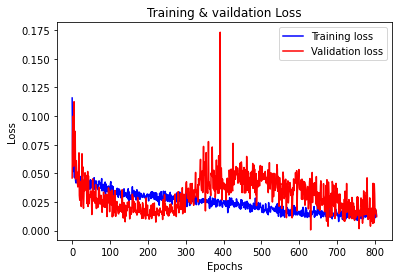

In [90]:
tsm.visualize_loss(history, "Training & vaildation Loss")

In [ ]:
#######################################################keras tunner_Bayesian Optimization
#######################################################(hp : lstm_units,dense_units, learning-rate)  layer?

In [62]:
from kerastuner.tuners import BayesianOptimization

In [63]:
n_input = 5
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))

    return model



In [66]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/Users/KIMYEONKYOUNG/Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(train_x, train_y,epochs=EPOCHS,
     validation_data=(val_x, val_y))#      validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


Invalid model 0/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


Invalid model 1/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


Invalid model 2/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


Invalid model 3/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-63-b277a0c48b7b>", line 12, in build_model
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
NameError: name 'keras' is not defined


RuntimeError: Too many failed attempts to build model.

In [121]:
#2 epoch con 20 max_trials
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=8,
                                        max_value=64,
                                        step=8), 
                   activation='relu', input_shape=x_train_uni.shape[-2:]))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                   metrics=['mse'])
    return model

# define model
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=2,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='timeseries_temp_ts_test_from_TF_ex',
    overwrite=True)

EVALUATION_INTERVAL = 30
EPOCHS = 2

bayesian_opt_tuner.search(train_univariate, #X_train, y_train,
             epochs=EPOCHS,
             validation_data=val_univariate,
             validation_steps=50,
             steps_per_epoch=EVALUATION_INTERVAL
             #batch_size=int(len(X_train)/2)
             #validation_split=0.2,verbose=1)
             )

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined


Invalid model 0/5
Invalid model 1/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined


Invalid model 2/5
Invalid model 3/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined


Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-121-75f0b156bbff>", line 7, in build_model
    activation='relu', input_shape=x_train_uni.shape[-2:]))
NameError: name 'x_train_uni' is not defined


RuntimeError: Too many failed attempts to build model.

 # predict

In [50]:
model = load_model('C:/Users/KIMYEONKYOUNG/Desktop/2021 AI 빅데이터팀/메탈 수요예측/code/lstm_model_checkpoint_minmax_epoch1000.h5')

In [107]:
ndt=np.asarray(df_test)
nddt=ndt.reshape(len(df_test),)
nddt.shape

(5,)

In [56]:
(xt, yt) = tsm.split_sequence(nddt, n_steps)

In [105]:
# xtt = xt.reshape(xt.shape[0], n_steps, n_features)

ValueError: cannot reshape array of size 5 into shape (5,5,1)

In [127]:
xtt = nddt.reshape(1, n_steps, n_features) 
xtt

array([[[0.07073615],
        [0.13120371],
        [0.06503794],
        [0.15522103],
        [0.34168819]]])

In [124]:
df_test

,0
Time,
2020-11-01,0.070736
2020-12-01,0.131204
2021-01-01,0.065038
2021-02-01,0.155221
2021-03-01,0.341688


In [132]:
yhat = simple_lstm_model.predict(xtt)#
prediction=pd.DataFrame(yhat)
prediction.columns=['yhat']
prediction.index=df_test[4:].index   # index 설정방법

In [133]:
prediction

,yhat
Time,
2021-03-01,0.217569


In [134]:
# prediction['prediction']=scal.inverse_transform(prediction['yhat']) # standard
# minmax
# yh=scal.transform(prediction['yhat'])
prediction['prediction']=scal.inverse_transform(prediction)

In [135]:
prediction

,yhat,prediction
Time,,
2021-03-01,0.217569,127.906097


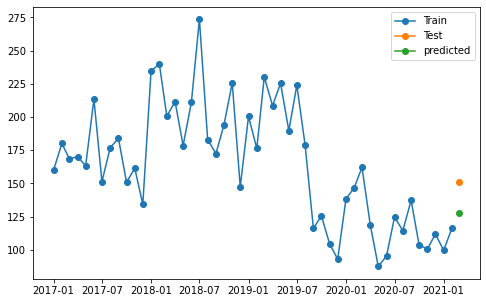

In [136]:
#graph
tsm.predict_graph(train,test_nu,prediction['prediction'])

In [138]:
output=pd.merge(test[4:],prediction['prediction'],left_index=True, right_index=True)
output

,삼성전자_실적,prediction
Time,,
2021-03-01,151.017,127.906097


# metric(평가)

In [63]:
# MSE,RMSE
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(output['prediction'],output[column])
rmse=np.sqrt(mean_squared_error(output['prediction'],output[column]))
print('MSE (%s)'%mse)
print('RMSE (%s)'%rmse)

MSE (788.0946319539503)
RMSE (28.07302320652249)


# Plan, Predict 비교

In [71]:
pred_col='삼성전자_실적'

In [69]:
plan_col='삼성전자_이동'

In [70]:
plan=tsm.ts_data(data,plan_col)

In [65]:
compare=pd.merge(output,plan,left_index=True, right_index=True)

In [72]:
compare['pred_diff']=abs(compare[pred_col]-compare['prediction'])
compare['plan_diff']=abs(compare[pred_col]-compare[plan_col])

In [73]:
compare

,삼성전자_실적,prediction,삼성전자_이동,pred_diff,plan_diff
Time,,,,,
2020-11-01,100.566,103.206734,120.0,2.640734,19.434
2020-12-01,111.825,143.298325,110.0,31.473325,1.825
2021-01-01,99.505,145.096207,147.0,45.591207,47.495
2021-02-01,116.297,141.345825,123.0,25.048825,6.703
2021-03-01,151.017,135.624542,149.0,15.392458,2.017
